# Data analysis in a notebook


## Hands on data analysis 


Enter xarray library: N-D labeled arrays and datasets in Python

Multi-dimensional (a.k.a. N-dimensional, ND) arrays (sometimes called “tensors”) are an essential part of computational science. They are encountered in a wide range of fields, including physics, astronomy, geoscience, bioinformatics, engineering, finance, and deep learning. In Python, NumPy provides the fundamental data structure and API for working with raw ND arrays. However, real-world datasets are usually more than just raw numbers; they have labels which encode information about how the array values map to locations in space, time, etc.

By introducing dimensions, coordinates, and attributes on top of raw NumPy-like arrays, xarray is able to understand these labels and use them to provide a more intuitive, more concise, and less error-prone experience. Xarray also provides a large and growing library of functions for advanced analytics and visualization with these data structures. Xarray was inspired by and borrows heavily from pandas, the popular data analysis package focused on labelled tabular data. Xarray can read and write data from most common labeled ND-array storage formats and is particularly tailored to working with netCDF files, which were the source of xarray’s data model.

Adding dimensions names and coordinate indexes to numpy’s ndarray makes many powerful array operations possible:

* Apply operations over dimensions by name: x.sum('time').
* Select values by label instead of integer location: x.loc['2014-01-01'] or x.sel(time='2014-01-01').
* Mathematical operations (e.g., x - y) vectorize across multiple dimensions (array broadcasting) based on dimension names, not shape.
* Flexible split-apply-combine operations with groupby: x.groupby('time.dayofyear').mean().
* Database like alignment based on coordinate labels that smoothly handles missing values: x, y = xr.align(x, y, join='outer').
* Keep track of arbitrary metadata in the form of a Python dictionary: x.attrs.

Let us open a dataset using the xarray package.


In [1]:
import os
import xarray

CMIP_directory = '.'
CMIP_file = 'tas_day_HadGEM2.nc'

data = xarray.open_dataset(os.path.join(CMIP_directory,CMIP_file))
print(data)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 145, lon: 192, time: 1080)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 -85.0 -83.75 -82.5 ...
  * lon        (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 2000-01-02T12:00:00 ...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) float64 ...
Attributes:
    institution:            Met Office Hadley Centre, Fitzroy Road, Exeter, D...
    institute_id:           MOHC
    experiment_id:          historical
    source:                 HadGEM2-ES (2009) atmosphere: HadGAM2 (N96L38); o...
    model_id:               HadGEM2-ES
    forcing:                GHG, SA, Oz, LU, Sl, Vl, BC, OC, (GHG = CO2, N2O,...
    parent_experiment_id:   piControl
    parent_experiment_rip: 

/usr/lib/python3/dist-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason:day is out of range for month
  return self.func(self.array[key])


But we could have easily opened a remote dataset through an OpenDap data server:

In [2]:
remote_data = xarray.open_dataset(
    'http://iridl.ldeo.columbia.edu/SOURCES/.OSU/.PRISM/.monthly/dods',
     decode_times=False)
print(remote_data)

<xarray.Dataset>
Dimensions:  (T: 1420, X: 1405, Y: 621)
Coordinates:
  * X        (X) float32 -125.0 -124.958336 -124.916664 -124.875 -124.833336 ...
  * T        (T) float32 -779.5 -778.5 -777.5 -776.5 -775.5 -774.5 -773.5 ...
  * Y        (Y) float32 49.916668 49.875 49.833336 49.791668 49.75 ...
Data variables:
    ppt      (T, Y, X) float64 ...
    tdmean   (T, Y, X) float64 ...
    tmax     (T, Y, X) float64 ...
    tmin     (T, Y, X) float64 ...
Attributes:
    Conventions:  IRIDL
    expires:      1370044800


### Access the data

The particular variables in xarray can be access using the handy dot syntax:


In [3]:
surface_temp = data.tas
print(surface_temp)

<xarray.DataArray 'tas' (time: 1080, lat: 145, lon: 192)>
[30067200 values with dtype=float32]
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 -85.0 -83.75 -82.5 ...
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 2000-01-02T12:00:00 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           daily-mean near-surface (usually, 2 meter) air tempera...
    units:             K
    original_name:     mo: m01s03i236
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2010-11-22T15:34:22Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...


Let us now select the valus for just two years, 2000 and 2001:


In [4]:
import cftime
import numpy as np

subset = data.loc[dict(  
                       time=slice(cftime.Datetime360Day(2000,1,1),
                                  cftime.Datetime360Day(2002,1,1)))
                 ]

And let us do a time average of this two years:

In [5]:
surface_temp_mean = xarray.DataArray(np.mean(subset.tas,axis=0))

WOW! Now let us plot this 2 year average on a map:

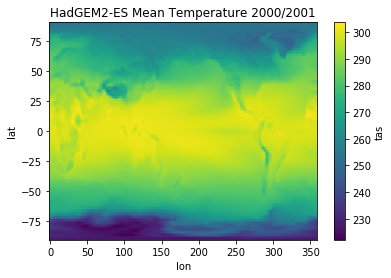

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

surface_temp_mean.plot( )
plt.title('HadGEM2-ES Mean Temperature 2000/2001')
plt.show( )

That was nice. Let us compute and plot the anomaly of this two year average over the 5 year mean data.

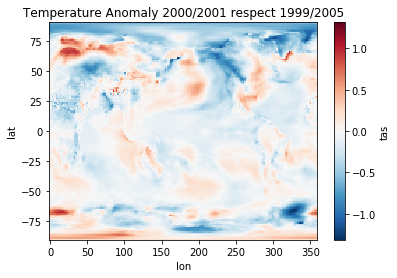

In [7]:
all_temp_mean = xarray.DataArray(np.mean(data.tas,axis=0))

anomaly = surface_temp_mean - all_temp_mean

anomaly.plot( )
plt.title('Temperature Anomaly 2000/2001 respect 1999/2005')
plt.show( )

Let us now load a measure dataset, say the CRU:

http://www.cru.uea.ac.uk/data

and compare it to our five year mean to get the BIAS.

In [8]:
OBS_directory = '.'
OBS_file = 'tmp.dat.nc'

cru = xarray.open_dataset(os.path.join(OBS_directory,OBS_file))
print(cru)

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 36)
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * lon      (lon) float32 -179.75 -179.25 -178.75 -178.25 -177.75 -177.25 ...
  * time     (time) datetime64[ns] 2000-01-16 2000-02-15 2000-03-16 ...
Data variables:
    stn      (time, lat, lon) int32 ...
    tmp      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.02 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 1811131722. Data generated from:tmp.1804231108.dtb
    history:      Tue Feb 12 17:47:15 2019: ncks -d time,2000-01-01T00:00:00,...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk
    NCO:          4.7.2


Select the same temporal window of the HadGEM2 dataset.

In [9]:
cruwin = cru.loc[dict(time=slice("1999-12-01T00:00:00",
                                 "2005-12-01T00:00:00"))
                ]

And now average the data over time. Note that we have also to do a unit of measure change:

In [10]:
print('CRU units : ',cruwin.tmp.units)
print('HadGEM units : ', subset.tas.units)


CRU units :  degrees Celsius
HadGEM units :  K


To convert in Kelvin, we have to add 273.15 K to the temperature in Celsius. We do this and save the data in a temporary file we will us later on for the interpolation using cdo.

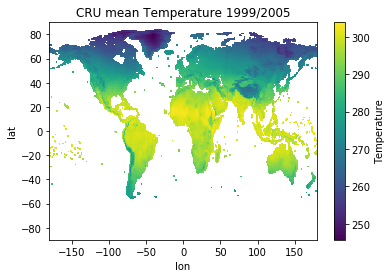

In [11]:
mean_cru = xarray.DataArray(np.mean(cruwin.tmp,axis=0)) + 273.15
mean_cru.to_netcdf('crumean.nc')

mean_cru.name = 'Temperature'
mean_cru.attrs.units = 'K'
mean_cru.plot()
plt.title('CRU mean Temperature 1999/2005')
plt.show( )

Let us resample the CRU grid to the Hadgem one.

In [12]:
import cdo

cdo = cdo.Cdo( )
gdes = "\n".join(cdo.griddes(
        input=os.path.join(CMIP_directory,CMIP_file)))

with open('grid.des', "w") as writer:
    writer.write(gdes)

remap_file = cdo.remapbil('grid.des',
                          input = 'crumean.nc',
                          output = 'ha_crumean.nc',
                          options = '-f nc')

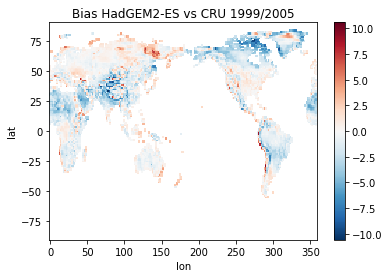

In [13]:
cru_had = xarray.open_dataset(remap_file)
bias = all_temp_mean - cru_had.tmp

bias.plot( )
plt.title('Bias HadGEM2-ES vs CRU 1999/2005')
plt.show( )

Some cleanup....

In [14]:
os.unlink('grid.des')
os.unlink('crumean.nc')
os.unlink('ha_crumean.nc')

Just one more map. we could have easiy used also gdal package!

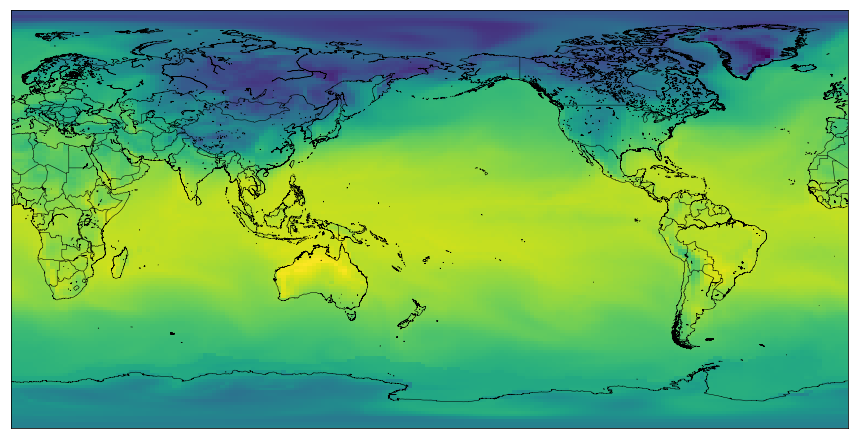

In [15]:
from osgeo import gdal
from mpl_toolkits.basemap import Basemap

ds = gdal.Open(os.path.join(CMIP_directory,CMIP_file))
bnd1 = ds.GetRasterBand(1).ReadAsArray()

fig = plt.figure(figsize=(15,15))  # a new figure window
ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
nx = ds.RasterXSize # Raster xsize
ny = ds.RasterYSize # Raster ysize

gt = ds.GetGeoTransform()
proj = ds.GetProjection()

xres = gt[1]
yres = gt[5]

xmin = 0.0 
xmax = 360.0
ymin = -90.0
ymax = 90.0 

map = Basemap(projection='cyl',llcrnrlat=ymin,urcrnrlat=ymax,\
            llcrnrlon=xmin,urcrnrlon=xmax , resolution='i', ax=ax)

map.imshow(bnd1, origin='upper', ax=ax)
map.drawcountries(color='black', linewidth=0.5, ax=ax)
map.drawcoastlines(linewidth=0.5, color='black', ax=ax)


That's All Folks!